In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
import random
# Machine Learning and Deep Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback

# Genetic Algorithm Libraries
import deap
from deap import base, creator, tools, algorithms

In [72]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [73]:
class EpochTimeCallback(Callback):
    """
    Custom callback to track epoch training times
    """
    def __init__(self):
        super().__init__()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        print(f"Epoch {epoch + 1} took {epoch_time:.4f} seconds")


In [77]:
class StrokeModelOptimizer:
    def __init__(self, filepath):
        """
        Initialize the optimizer with data and genetic algorithm parameters
        
        Parameters:
        -----------
        filepath : str
            Path to the stroke prediction dataset
        """
        # Data Loading and Preprocessing
        self.X_train, self.X_test, self.y_train, self.y_test, self.scaler = self.load_and_preprocess_data(filepath)
        
        # GA Configuration
        self.POPULATION_SIZE = 10
        self.MAX_GENERATIONS = 10
        self.CROSSOVER_PROB = 0.7
        self.MUTATION_PROB = 0.2
        
        # Chromosome Gene Ranges with Explicit Constraints
        self.GENE_CONFIGS = {
            'neurons_layer1': (16, 128),   # First layer neurons
            'neurons_layer2': (8, 64),     # Second layer neurons
            'dropout_rate1': (0.1, 0.5),   # First dropout rate
            'dropout_rate2': (0.1, 0.3),   # Second dropout rate
            'learning_rate': (1e-4, 1e-2), # Learning rate
            'l2_reg': (1e-4, 1e-2)         # L2 regularization strength
        }
        
        # Optimization Constraints
        self.CONSTRAINTS = {
            'min_accuracy': 0.75,
            'max_false_negative_rate': 0.2,
            'min_recall': 0.7,
            'max_training_time': 300,  # 5 minutes
            'max_total_params': 10000
        }
        
        # Setup DEAP framework
        self.setup_deap_framework()
        
    def load_and_preprocess_data(self, filepath):
        """
        Load and preprocess stroke prediction dataset
        """
        df = pd.read_csv(filepath)
        X = df.drop('stroke', axis=1)
        y = df['stroke']
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        return X_train_scaled, X_test_scaled, y_train, y_test, scaler
    
    def setup_deap_framework(self):
        """
        Setup DEAP's multi-objective optimization framework
        """
        # Multi-objective maximization problem
        creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0, -1.0, 1.0))
        creator.create("Individual", list, fitness=creator.FitnessMulti)
        
        # Toolbox setup
        self.toolbox = base.Toolbox()
        
        # Gene generation functions
        for gene, (low, high) in self.GENE_CONFIGS.items():
            self.toolbox.register(f"attr_{gene}", random.uniform, low, high)
        
        # Individual and population creation
        self.toolbox.register("individual", 
                               tools.initCycle, 
                               creator.Individual,
                               (self.toolbox.attr_neurons_layer1, 
                                self.toolbox.attr_neurons_layer2,
                                self.toolbox.attr_dropout_rate1,
                                self.toolbox.attr_dropout_rate2,
                                self.toolbox.attr_learning_rate,
                                self.toolbox.attr_l2_reg), 
                               n=1)
        
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        
        # Genetic Operators
        self.toolbox.register("evaluate", self.evaluate_individual)
        self.toolbox.register("mate", tools.cxBlend, alpha=0.5)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
        self.toolbox.register("select", tools.selNSGA2)
        
    def create_ann_model(self, individual):
        """
        Create ANN model with explicit constraints
        """
        neurons_layer1, neurons_layer2, dropout1, dropout2, learning_rate, l2_reg = individual

        # Constraint Checks
        neurons_layer1 = max(16, min(128, int(neurons_layer1)))
        neurons_layer2 = max(8, min(64, int(neurons_layer2)))
        dropout1 = max(0.1, min(0.5, dropout1))
        dropout2 = max(0.1, min(0.3, dropout2))
        learning_rate = max(1e-4, min(1e-2, learning_rate))
        l2_reg = max(1e-4, min(1e-2, l2_reg))

        model = Sequential([
            Dense(neurons_layer1, activation='relu', 
                  input_shape=(self.X_train.shape[1],), 
                  kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
            Dropout(dropout1),
            Dense(neurons_layer2, activation='relu', 
                  kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
            Dropout(dropout2),
            Dense(1, activation='sigmoid')
        ])

        # Check total model parameters
        total_params = sum([layer.count_params() for layer in model.layers])
        if total_params > self.CONSTRAINTS['max_total_params']:
            raise ValueError("Model exceeds maximum parameter constraint")

        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model
    
    def train_model_with_tqdm(self, model, X_train, y_train):
        """
        Train model with TQDM progress tracking
        """
        epochs = 5
        progress_bar = tqdm(range(epochs), desc="Training Progress", unit="epoch")
        
        # Epoch time tracking callback
        epoch_time_callback = EpochTimeCallback()
        
        # Early stopping
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
        
        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=epochs,
            batch_size=64,
            callbacks=[
                early_stopping,
                epoch_time_callback,
                tf.keras.callbacks.LambdaCallback(
                    on_epoch_end=lambda epoch, logs: progress_bar.set_postfix(
                        loss=f"{logs.get('loss'):.4f}",
                        val_loss=f"{logs.get('val_loss'):.4f}"
                    )
                )
            ],
            verbose=0
        )
        
        progress_bar.close()
        return history, epoch_time_callback
    
    def evaluate_individual(self, individual):
        """
        Enhanced evaluation with performance constraints
        """
        try:
            # Create and train model
            model = self.create_ann_model(individual)
            start_time = time.time()
            
            history, epoch_time_callback = self.train_model_with_tqdm(
                model, self.X_train, self.y_train
            )
            
            training_time = time.time() - start_time
            
            # Performance Metrics with Constraint Checks
            y_pred_proba = model.predict(self.X_test)
            y_pred = (y_pred_proba > 0.5).astype(int)
            
            accuracy = accuracy_score(self.y_test, y_pred)
            recall = recall_score(self.y_test, y_pred)
            false_negative_rate = np.sum((y_pred == 0) & (self.y_test == 1)) / np.sum(self.y_test == 1)
            
            # Constraint Validation
            if (accuracy < self.CONSTRAINTS['min_accuracy'] or 
                recall < self.CONSTRAINTS['min_recall'] or 
                false_negative_rate > self.CONSTRAINTS['max_false_negative_rate'] or 
                training_time > self.CONSTRAINTS['max_training_time']):
                return 1.0, float('inf'), float('inf'), 0.0
            
            return (
                false_negative_rate,    # Minimize
                training_time,           # Minimize
                model.count_params(),    # Minimize
                accuracy                 # Maximize
            )
        except Exception as e:
            print(f"Evaluation Error: {e}")
            return 1.0, float('inf'), float('inf'), 0.0
        
    def run_optimization(self):
        """
        Run multi-objective genetic algorithm optimization
        """
        # Initialize population
        population = self.toolbox.population(n=self.POPULATION_SIZE)
        
        # Hall of Fame to track best solutions
        hall_of_fame = tools.ParetoFront()
        
        # Create statistics tracker
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean, axis=0)
        stats.register("min", np.min, axis=0)
        
        # Run NSGA-II algorithm
        population, logbook = algorithms.eaMuPlusLambda(
            population, 
            self.toolbox, 
            mu=self.POPULATION_SIZE, 
            lambda_=self.POPULATION_SIZE, 
            cxpb=self.CROSSOVER_PROB, 
            mutpb=self.MUTATION_PROB, 
            stats=stats,
            halloffame=hall_of_fame, 
            ngen=self.MAX_GENERATIONS,
            verbose=True
        )
        
        return hall_of_fame, population, logbook
    
    def visualize_optimization_results(self, hall_of_fame, logbook):
        """
        Visualization of genetic algorithm optimization process
        """
        plt.figure(figsize=(20, 15))
        
        # 1. Pareto Front Visualization
        plt.subplot(2, 2, 1)
        pareto_front = np.array([ind.fitness.values for ind in hall_of_fame])
        plt.scatter(pareto_front[:, 0], pareto_front[:, 1], 
                    c=pareto_front[:, 3], cmap='viridis')
        plt.title('Pareto Front: False Negative Rate vs Training Time')
        plt.xlabel('False Negative Rate')
        plt.ylabel('Training Time')
        plt.colorbar(label='Accuracy')
        
        # 2. Convergence Plot
        plt.subplot(2, 2, 2)
        gen_stats = logbook.select("gen")
        avg_fitness = logbook.select("avg")
        plt.plot(gen_stats, [x[0] for x in avg_fitness], label='Avg False Negative Rate')
        plt.plot(gen_stats, [x[1] for x in avg_fitness], label='Avg Training Time')
        plt.title('Optimization Convergence')
        plt.xlabel('Generations')
        plt.ylabel('Metric Value')
        plt.legend()
        
        # 3. Best Individual Performance Tracking
        plt.subplot(2, 2, 3)
        best_individuals = [ind for ind in hall_of_fame]
        metrics = np.array([ind.fitness.values for ind in best_individuals])
        metrics_names = ['False Negative Rate', 'Training Time', 'Model Complexity', 'Accuracy']
        
        for i in range(4):
            plt.plot(metrics[:, i], label=metrics_names[i])
        plt.title('Best Individual Metrics Progression')
        plt.xlabel('Pareto Solutions')
        plt.ylabel('Metric Value')
        plt.legend()
        
        # 4. Distribution of Hyperparameters
        plt.subplot(2, 2, 4)
        hyperparams = np.array([list(ind)[:4] for ind in hall_of_fame])
        param_names = list(self.GENE_CONFIGS.keys())[:4]
        for i in range(4):
            plt.hist(hyperparams[:, i], bins=20, alpha=0.5, label=param_names[i])
        plt.title('Hyperparameter Distribution')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
    def visualize_epoch_training_times(self, epoch_times):
        """
        Visualize epoch training times
        """
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(epoch_times) + 1), epoch_times, marker='o')
        plt.title('Epoch Training Times')
        plt.xlabel('Epoch')
        plt.ylabel('Training Time (seconds)')
        plt.tight_layout()
        plt.show()

    def visualize_best_model_performance(self, best_model, X_test, y_test):
        """
        Comprehensive model performance visualization
        """
        plt.figure(figsize=(20, 10))
        
        # Predictions
        y_pred_proba = best_model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        # 1. Confusion Matrix
        plt.subplot(2, 2, 1)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        
        # 2. Classification Report
        plt.subplot(2, 2, 2)
        class_report = classification_report(y_test, y_pred, output_dict=True)
        report_df = pd.DataFrame(class_report).transpose()
        sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='YlGnBu')
        plt.title('Classification Metrics')
        
        # 3. ROC Curve
        plt.subplot(2, 3, 3)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        
        # 4. Precision-Recall Curve
        plt.subplot(2, 3, 4)
        from sklearn.metrics import precision_recall_curve, average_precision_score
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        avg_precision = average_precision_score(y_test, y_pred_proba)
        plt.step(recall, precision, color='b', alpha=0.2, where='post')
        plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve (AP = {avg_precision:.2f})')
        
        # 5. Distribution of Predictions
        plt.subplot(2, 3, 5)
        plt.hist([y_pred_proba[y_test == 0], y_pred_proba[y_test == 1]], 
                 label=['Negative', 'Positive'], 
                 color=['blue', 'red'], 
                 alpha=0.6, 
                 bins=30)
        plt.title('Distribution of Prediction Probabilities')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Frequency')
        plt.legend()
        
        # 6. Prediction Error Analysis
        plt.subplot(2, 3, 6)
        prediction_errors = np.abs(y_test - y_pred_proba.ravel())
        plt.hist(prediction_errors, bins=30, color='green', alpha=0.7)
        plt.title('Prediction Error Distribution')
        plt.xlabel('Absolute Prediction Error')
        plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
    

In [78]:
def main():
    """
    Main function to run the stroke prediction model optimization
    """
    # Replace with your actual dataset path
    filepath = r'C:\Users\HP\Documents\GitHub\ci-coursework\cleaned-stroke-prediction-dataset-balanced.csv'
    
    # Initialize the optimizer
    optimizer = StrokeModelOptimizer(filepath)
    
    # Run multi-objective optimization
    hall_of_fame, population, logbook = optimizer.run_optimization()
    
    # Visualize optimization results
    optimizer.visualize_optimization_results(hall_of_fame, logbook)
    
    # Select the best individual (first in the Pareto front)
    best_individual = hall_of_fame[0]
    
    # Create and train the best model
    best_model = optimizer.create_ann_model(best_individual)
    
    # Train the model with tqdm and get epoch times
    history, epoch_time_callback = optimizer.train_model_with_tqdm(
        best_model, optimizer.X_train, optimizer.y_train
    )
    
    # Visualize epoch training times
    optimizer.visualize_epoch_training_times(epoch_time_callback.epoch_times)
    
    # Visualize best model performance
    optimizer.visualize_best_model_performance(best_model, optimizer.X_test, optimizer.y_test)
    
    # Optional: Save best model
    best_model.save('best_stroke_prediction_model.h5')
    print("Best model saved successfully!")


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **k

Epoch 1 took 2.8345 seconds


Training Progress:   0%|          | 0/5 [00:03<?, ?epoch/s, loss=0.2812, val_loss=0.2743]

Epoch 2 took 0.2984 seconds


Training Progress:   0%|          | 0/5 [00:03<?, ?epoch/s, loss=0.2667, val_loss=0.2611]

Epoch 3 took 0.3402 seconds


Training Progress:   0%|          | 0/5 [00:03<?, ?epoch/s, loss=0.2521, val_loss=0.2528]

Epoch 4 took 0.3032 seconds


Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.2388, val_loss=0.2493]

Epoch 5 took 0.3427 seconds
41/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.7361, val_loss=0.4807]

Epoch 1 took 1.4347 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4464, val_loss=0.3699]

Epoch 2 took 0.2802 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3658, val_loss=0.3297]

Epoch 3 took 0.2861 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3270, val_loss=0.3099]

Epoch 4 took 0.2742 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3149, val_loss=0.3024]

Epoch 5 took 0.2769 seconds
47/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=1.0741, val_loss=0.7185]

Epoch 1 took 1.3178 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5941, val_loss=0.4775]

Epoch 2 took 0.2748 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4363, val_loss=0.3868]

Epoch 3 took 0.3070 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3703, val_loss=0.3471]

Epoch 4 took 0.2922 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3361, val_loss=0.3278]

Epoch 5 took 0.2695 seconds
51/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5894, val_loss=0.3810]

Epoch 1 took 1.4245 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3387, val_loss=0.3158]

Epoch 2 took 0.2814 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3014, val_loss=0.2984]

Epoch 3 took 0.3057 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2884, val_loss=0.2923]

Epoch 4 took 0.2988 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2843, val_loss=0.2868]

Epoch 5 took 0.2856 seconds
48/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4558, val_loss=0.3384]

Epoch 1 took 1.3011 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3240, val_loss=0.2980]

Epoch 2 took 0.2949 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.2887, val_loss=0.2830]

Epoch 3 took 0.2834 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2815, val_loss=0.2796]

Epoch 4 took 0.3760 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2737, val_loss=0.2748]

Epoch 5 took 0.2855 seconds
48/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5028, val_loss=0.3457]

Epoch 1 took 1.2728 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3587, val_loss=0.3243]

Epoch 2 took 0.5655 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3457, val_loss=0.3170]

Epoch 3 took 0.3013 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3422, val_loss=0.3210]

Epoch 4 took 0.3096 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3355, val_loss=0.3127]

Epoch 5 took 0.3075 seconds
53/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4902, val_loss=0.3718]

Epoch 1 took 1.2991 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3345, val_loss=0.3160]

Epoch 2 took 0.2677 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.2936, val_loss=0.2916]

Epoch 3 took 0.2973 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2769, val_loss=0.2842]

Epoch 4 took 0.3923 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2691, val_loss=0.2775]

Epoch 5 took 0.2694 seconds
41/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5169, val_loss=0.3600]

Epoch 1 took 1.4824 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3181, val_loss=0.3012]

Epoch 2 took 0.5350 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2879, val_loss=0.2870]

Epoch 3 took 0.2680 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2786, val_loss=0.2805]

Epoch 4 took 0.3469 seconds


Training Progress:   0%|          | 0/5 [00:03<?, ?epoch/s, loss=0.2693, val_loss=0.2811]

Epoch 5 took 0.2914 seconds
56/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5692, val_loss=0.3574]

Epoch 1 took 1.2675 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3439, val_loss=0.3234]

Epoch 2 took 0.2789 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3253, val_loss=0.3103]

Epoch 3 took 0.3140 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3235, val_loss=0.3092]

Epoch 4 took 0.3118 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3213, val_loss=0.3083]

Epoch 5 took 0.3876 seconds
33/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.5580, val_loss=0.4003]

Epoch 1 took 2.1830 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3603, val_loss=0.3332]

Epoch 2 took 0.2742 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3133, val_loss=0.3081]

Epoch 3 took 0.2683 seconds


Training Progress:   0%|          | 0/5 [00:03<?, ?epoch/s, loss=0.2914, val_loss=0.2960]

Epoch 4 took 0.2669 seconds


Training Progress:   0%|          | 0/5 [00:03<?, ?epoch/s, loss=0.2826, val_loss=0.2878]

Epoch 5 took 0.2723 seconds
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
gen	nevals	avg              	min              
0  	10    	[ 1. inf inf  0.]	[ 1. inf inf  0.]


Training Progress:   0%|          | 0/5 [00:03<?, ?epoch/s, loss=0.5787, val_loss=0.3485]

Epoch 1 took 3.0895 seconds


Training Progress:   0%|          | 0/5 [00:03<?, ?epoch/s, loss=0.3220, val_loss=0.3066]

Epoch 2 took 0.7834 seconds


Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.2999, val_loss=0.2980]

Epoch 3 took 0.7351 seconds


Training Progress:   0%|          | 0/5 [00:05<?, ?epoch/s, loss=0.2953, val_loss=0.2957]

Epoch 4 took 1.2842 seconds


Training Progress:   0%|          | 0/5 [00:07<?, ?epoch/s, loss=0.2922, val_loss=0.2942]

Epoch 5 took 1.2730 seconds


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.5999, val_loss=0.3884]

Epoch 1 took 3.9759 seconds


Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.3648, val_loss=0.3276]

Epoch 2 took 0.7662 seconds


Training Progress:   0%|          | 0/5 [00:05<?, ?epoch/s, loss=0.3217, val_loss=0.3078]

Epoch 3 took 0.7616 seconds


Training Progress:   0%|          | 0/5 [00:06<?, ?epoch/s, loss=0.3069, val_loss=0.2964]

Epoch 4 took 0.7403 seconds


Training Progress:   0%|          | 0/5 [00:07<?, ?epoch/s, loss=0.2956, val_loss=0.2920]

Epoch 5 took 0.7604 seconds


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.4543, val_loss=0.3297]

Epoch 1 took 4.0537 seconds


Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.3272, val_loss=0.3071]

Epoch 2 took 0.7723 seconds


Training Progress:   0%|          | 0/5 [00:05<?, ?epoch/s, loss=0.3140, val_loss=0.3011]

Epoch 3 took 0.8115 seconds


Training Progress:   0%|          | 0/5 [00:06<?, ?epoch/s, loss=0.3079, val_loss=0.2979]

Epoch 4 took 0.7551 seconds


Training Progress:   0%|          | 0/5 [00:07<?, ?epoch/s, loss=0.3080, val_loss=0.2958]

Epoch 5 took 0.7610 seconds


Training Progress:   0%|          | 0/5 [00:07<?, ?epoch/s, loss=0.3080, val_loss=0.2958]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.9506, val_loss=0.8696]

Epoch 1 took 3.9689 seconds


Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.8556, val_loss=0.7988]

Epoch 2 took 0.7911 seconds


Training Progress:   0%|          | 0/5 [00:06<?, ?epoch/s, loss=0.7919, val_loss=0.7442]

Epoch 3 took 1.2948 seconds


Training Progress:   0%|          | 0/5 [00:06<?, ?epoch/s, loss=0.7417, val_loss=0.6981]

Epoch 4 took 0.7582 seconds


Training Progress:   0%|          | 0/5 [00:07<?, ?epoch/s, loss=0.6964, val_loss=0.6576]

Epoch 5 took 0.8124 seconds


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.7679, val_loss=0.5304]

Epoch 1 took 4.0831 seconds


Training Progress:   0%|          | 0/5 [00:05<?, ?epoch/s, loss=0.4735, val_loss=0.4055]

Epoch 2 took 0.8474 seconds


Training Progress:   0%|          | 0/5 [00:05<?, ?epoch/s, loss=0.3793, val_loss=0.3510]

Epoch 3 took 0.7442 seconds


Training Progress:   0%|          | 0/5 [00:07<?, ?epoch/s, loss=0.3368, val_loss=0.3280]

Epoch 4 took 1.2572 seconds


Training Progress:   0%|          | 0/5 [00:08<?, ?epoch/s, loss=0.3133, val_loss=0.3122]

Epoch 5 took 1.3387 seconds


Training Progress:   0%|          | 0/5 [00:09<?, ?epoch/s, loss=0.3133, val_loss=0.3122]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.5277, val_loss=0.4053]

Epoch 1 took 3.8999 seconds


Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.3552, val_loss=0.3337]

Epoch 2 took 0.6964 seconds


Training Progress:   0%|          | 0/5 [00:05<?, ?epoch/s, loss=0.3052, val_loss=0.3046]

Epoch 3 took 0.7138 seconds


Training Progress:   0%|          | 0/5 [00:06<?, ?epoch/s, loss=0.2854, val_loss=0.2895]

Epoch 4 took 0.7212 seconds


Training Progress:   0%|          | 0/5 [00:06<?, ?epoch/s, loss=0.2730, val_loss=0.2843]

Epoch 5 took 0.7327 seconds


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.5189, val_loss=0.3536]

Epoch 1 took 3.9769 seconds


Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.3245, val_loss=0.3042]

Epoch 2 took 0.7152 seconds


Training Progress:   0%|          | 0/5 [00:05<?, ?epoch/s, loss=0.2936, val_loss=0.2884]

Epoch 3 took 0.9076 seconds


Training Progress:   0%|          | 0/5 [00:06<?, ?epoch/s, loss=0.2811, val_loss=0.2833]

Epoch 4 took 0.7367 seconds


Training Progress:   0%|          | 0/5 [00:07<?, ?epoch/s, loss=0.2815, val_loss=0.2811]

Epoch 5 took 0.7231 seconds


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.5643, val_loss=0.3737]

Epoch 1 took 4.1389 seconds


Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.3400, val_loss=0.3162]

Epoch 2 took 0.6973 seconds


Training Progress:   0%|          | 0/5 [00:05<?, ?epoch/s, loss=0.3013, val_loss=0.2996]

Epoch 3 took 0.7995 seconds


Training Progress:   0%|          | 0/5 [00:06<?, ?epoch/s, loss=0.2895, val_loss=0.2906]

Epoch 4 took 1.2325 seconds


Training Progress:   0%|          | 0/5 [00:07<?, ?epoch/s, loss=0.2809, val_loss=0.2826]

Epoch 5 took 0.6987 seconds


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.5898, val_loss=0.4223]

Epoch 1 took 4.1208 seconds


Training Progress:   0%|          | 0/5 [00:05<?, ?epoch/s, loss=0.4047, val_loss=0.3612]

Epoch 2 took 0.8838 seconds


Training Progress:   0%|          | 0/5 [00:05<?, ?epoch/s, loss=0.3488, val_loss=0.3302]

Epoch 3 took 0.6679 seconds


Training Progress:   0%|          | 0/5 [00:06<?, ?epoch/s, loss=0.3218, val_loss=0.3135]

Epoch 4 took 0.5850 seconds


Training Progress:   0%|          | 0/5 [00:07<?, ?epoch/s, loss=0.3076, val_loss=0.2992]

Epoch 5 took 0.6010 seconds
 1/59 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
1  	9     	[ 1. inf inf  0.]	[ 1. inf inf  0.]


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=1.0826, val_loss=0.7895]

Epoch 1 took 1.4137 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6941, val_loss=0.5663]

Epoch 2 took 0.2356 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5295, val_loss=0.4556]

Epoch 3 took 0.2665 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.4338, val_loss=0.3978]

Epoch 4 took 0.2678 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3857, val_loss=0.3609]

Epoch 5 took 0.3142 seconds
44/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6497, val_loss=0.4471]

Epoch 1 took 1.3979 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4014, val_loss=0.3550]

Epoch 2 took 0.3026 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3360, val_loss=0.3210]

Epoch 3 took 0.2674 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3096, val_loss=0.3075]

Epoch 4 took 0.3009 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2997, val_loss=0.2979]

Epoch 5 took 0.2670 seconds
 1/59 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.7240, val_loss=0.5044]

Epoch 1 took 1.4807 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4608, val_loss=0.3914]

Epoch 2 took 0.4322 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3758, val_loss=0.3475]

Epoch 3 took 0.2667 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3352, val_loss=0.3211]

Epoch 4 took 0.3249 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3116, val_loss=0.3059]

Epoch 5 took 0.2609 seconds
44/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5467, val_loss=0.3508]

Epoch 1 took 1.2942 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3293, val_loss=0.3126]

Epoch 2 took 0.3007 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3089, val_loss=0.3016]

Epoch 3 took 0.3456 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3033, val_loss=0.2964]

Epoch 4 took 0.3777 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3015, val_loss=0.2957]

Epoch 5 took 0.4441 seconds
 1/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.4618, val_loss=0.3379]

Epoch 1 took 2.1231 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3075, val_loss=0.2926]

Epoch 2 took 0.2769 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2839, val_loss=0.2823]

Epoch 3 took 0.2812 seconds


Training Progress:   0%|          | 0/5 [00:03<?, ?epoch/s, loss=0.2726, val_loss=0.2795]

Epoch 4 took 0.2804 seconds


Training Progress:   0%|          | 0/5 [00:03<?, ?epoch/s, loss=0.2707, val_loss=0.2773]

Epoch 5 took 0.2795 seconds
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:03<?, ?epoch/s, loss=0.3833, val_loss=0.3047]

Epoch 1 took 3.3026 seconds


Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.2948, val_loss=0.2781]

Epoch 2 took 0.7590 seconds


Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.2743, val_loss=0.2747]

Epoch 3 took 0.7773 seconds


Training Progress:   0%|          | 0/5 [00:05<?, ?epoch/s, loss=0.2668, val_loss=0.2665]

Epoch 4 took 0.8057 seconds


Training Progress:   0%|          | 0/5 [00:06<?, ?epoch/s, loss=0.2587, val_loss=0.2683]

Epoch 5 took 0.7807 seconds


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=1.0368, val_loss=0.6996]

Epoch 1 took 4.1652 seconds


Training Progress:   0%|          | 0/5 [00:05<?, ?epoch/s, loss=0.5830, val_loss=0.4773]

Epoch 2 took 0.7898 seconds


Training Progress:   0%|          | 0/5 [00:05<?, ?epoch/s, loss=0.4365, val_loss=0.3907]

Epoch 3 took 0.7776 seconds


Training Progress:   0%|          | 0/5 [00:06<?, ?epoch/s, loss=0.3715, val_loss=0.3520]

Epoch 4 took 0.7790 seconds


Training Progress:   0%|          | 0/5 [00:07<?, ?epoch/s, loss=0.3388, val_loss=0.3309]

Epoch 5 took 0.7889 seconds


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.5431, val_loss=0.3359]

Epoch 1 took 4.1630 seconds


Training Progress:   0%|          | 0/5 [00:05<?, ?epoch/s, loss=0.3206, val_loss=0.3087]

Epoch 2 took 0.7782 seconds


Training Progress:   0%|          | 0/5 [00:05<?, ?epoch/s, loss=0.3096, val_loss=0.3064]

Epoch 3 took 0.8144 seconds


Training Progress:   0%|          | 0/5 [00:06<?, ?epoch/s, loss=0.3021, val_loss=0.3002]

Epoch 4 took 0.7620 seconds


Training Progress:   0%|          | 0/5 [00:07<?, ?epoch/s, loss=0.2975, val_loss=0.2972]


Epoch 5 took 0.7835 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.5528, val_loss=0.3576]

Epoch 1 took 4.1081 seconds


Training Progress:   0%|          | 0/5 [00:05<?, ?epoch/s, loss=0.3808, val_loss=0.3372]

Epoch 2 took 0.7951 seconds


Training Progress:   0%|          | 0/5 [00:05<?, ?epoch/s, loss=0.3591, val_loss=0.3254]

Epoch 3 took 0.7448 seconds


Training Progress:   0%|          | 0/5 [00:06<?, ?epoch/s, loss=0.3527, val_loss=0.3206]

Epoch 4 took 0.6220 seconds


Training Progress:   0%|          | 0/5 [00:07<?, ?epoch/s, loss=0.3430, val_loss=0.3176]

Epoch 5 took 0.6883 seconds
 1/59 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.6027, val_loss=0.3503]

Epoch 1 took 3.9367 seconds


Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.3374, val_loss=0.3215]

Epoch 2 took 0.8202 seconds


Training Progress:   0%|          | 0/5 [00:05<?, ?epoch/s, loss=0.3213, val_loss=0.3151]

Epoch 3 took 0.8076 seconds


Training Progress:   0%|          | 0/5 [00:06<?, ?epoch/s, loss=0.3210, val_loss=0.3100]

Epoch 4 took 0.7924 seconds


Training Progress:   0%|          | 0/5 [00:07<?, ?epoch/s, loss=0.3156, val_loss=0.3126]

Epoch 5 took 0.7732 seconds


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
2  	10    	[ 1. inf inf  0.]	[ 1. inf inf  0.]


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/5 [00:04<?, ?epoch/s, loss=0.5224, val_loss=0.3400]

Epoch 1 took 4.1176 seconds


Training Progress:   0%|          | 0/5 [00:05<?, ?epoch/s, loss=0.3518, val_loss=0.3331]

Epoch 2 took 0.8063 seconds


Training Progress:   0%|          | 0/5 [00:05<?, ?epoch/s, loss=0.3473, val_loss=0.3308]

Epoch 3 took 0.7137 seconds


Training Progress:   0%|          | 0/5 [00:07<?, ?epoch/s, loss=0.3449, val_loss=0.3270]

Epoch 4 took 1.2523 seconds


Training Progress:   0%|          | 0/5 [00:07<?, ?epoch/s, loss=0.3467, val_loss=0.3305]

Epoch 5 took 0.5061 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4542, val_loss=0.3340]

Epoch 1 took 1.2395 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3107, val_loss=0.2954]

Epoch 2 took 0.2673 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.2882, val_loss=0.2826]

Epoch 3 took 0.3089 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2755, val_loss=0.2787]

Epoch 4 took 0.2700 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2720, val_loss=0.2733]

Epoch 5 took 0.2982 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5976, val_loss=0.3706]

Epoch 1 took 1.2421 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3428, val_loss=0.3173]

Epoch 2 took 0.2672 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3203, val_loss=0.3066]

Epoch 3 took 0.3008 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3136, val_loss=0.3057]

Epoch 4 took 0.3069 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3024, val_loss=0.2980]

Epoch 5 took 0.2828 seconds
52/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4640, val_loss=0.3391]

Epoch 1 took 1.1767 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3172, val_loss=0.2987]

Epoch 2 took 0.5683 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2885, val_loss=0.2830]

Epoch 3 took 0.3048 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2784, val_loss=0.2737]

Epoch 4 took 0.2817 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2708, val_loss=0.2711]

Epoch 5 took 0.2980 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.7728, val_loss=0.4973]

Epoch 1 took 1.2077 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4322, val_loss=0.3731]

Epoch 2 took 0.5688 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3463, val_loss=0.3281]

Epoch 3 took 0.3368 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3146, val_loss=0.3127]

Epoch 4 took 0.2667 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3008, val_loss=0.3026]

Epoch 5 took 0.3074 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5398, val_loss=0.3455]

Epoch 1 took 1.3193 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3182, val_loss=0.3040]

Epoch 2 took 0.2969 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.2941, val_loss=0.2972]

Epoch 3 took 0.2697 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2851, val_loss=0.2914]

Epoch 4 took 0.2976 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2822, val_loss=0.2851]

Epoch 5 took 0.2920 seconds
50/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.8325, val_loss=0.5621]

Epoch 1 took 1.1675 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5321, val_loss=0.4276]

Epoch 2 took 0.2522 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4182, val_loss=0.3681]

Epoch 3 took 0.2773 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3645, val_loss=0.3354]

Epoch 4 took 0.4150 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3359, val_loss=0.3190]

Epoch 5 took 0.3747 seconds
34/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5167, val_loss=0.3619]

Epoch 1 took 1.2592 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3220, val_loss=0.3052]

Epoch 2 took 0.3148 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.2898, val_loss=0.2901]

Epoch 3 took 0.2703 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2785, val_loss=0.2858]

Epoch 4 took 0.2960 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2729, val_loss=0.2775]

Epoch 5 took 0.2660 seconds
 1/59 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4294, val_loss=0.3335]

Epoch 1 took 1.2400 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3097, val_loss=0.2943]

Epoch 2 took 0.2672 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.2806, val_loss=0.2803]

Epoch 3 took 0.3274 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2699, val_loss=0.2705]

Epoch 4 took 0.2677 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2664, val_loss=0.2716]

Epoch 5 took 0.3160 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
3  	9     	[ 1. inf inf  0.]	[ 1. inf inf  0.]


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5529, val_loss=0.3852]

Epoch 1 took 1.1952 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3488, val_loss=0.2964]

Epoch 2 took 0.2517 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3019, val_loss=0.2791]

Epoch 3 took 0.3113 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2831, val_loss=0.2693]

Epoch 4 took 0.2857 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2659, val_loss=0.2624]

Epoch 5 took 0.3041 seconds
41/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4540, val_loss=0.3423]

Epoch 1 took 1.2723 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3180, val_loss=0.3011]

Epoch 2 took 0.2360 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.2883, val_loss=0.2879]

Epoch 3 took 0.2665 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2771, val_loss=0.2753]

Epoch 4 took 0.2798 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2710, val_loss=0.2791]

Epoch 5 took 0.2671 seconds
42/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6137, val_loss=0.3867]

Epoch 1 took 1.2200 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3497, val_loss=0.3254]

Epoch 2 took 0.2517 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3222, val_loss=0.3151]

Epoch 3 took 0.2656 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3192, val_loss=0.3063]

Epoch 4 took 0.3225 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3093, val_loss=0.3036]

Epoch 5 took 0.3005 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.7986, val_loss=0.5260]

Epoch 1 took 1.2148 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4618, val_loss=0.3870]

Epoch 2 took 0.5982 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3633, val_loss=0.3414]

Epoch 3 took 0.2835 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3321, val_loss=0.3199]

Epoch 4 took 0.3591 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3141, val_loss=0.3099]

Epoch 5 took 0.3196 seconds
41/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5615, val_loss=0.3609]

Epoch 1 took 1.2853 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3343, val_loss=0.3096]

Epoch 2 took 0.2672 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3124, val_loss=0.3018]

Epoch 3 took 0.2672 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2980, val_loss=0.2952]

Epoch 4 took 0.3005 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2943, val_loss=0.2876]

Epoch 5 took 0.2578 seconds
37/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5545, val_loss=0.3447]

Epoch 1 took 1.2179 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3219, val_loss=0.3115]

Epoch 2 took 0.6585 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3057, val_loss=0.3051]

Epoch 3 took 0.3294 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3026, val_loss=0.2921]

Epoch 4 took 0.3199 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2976, val_loss=0.2962]

Epoch 5 took 0.3908 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=1.0565, val_loss=0.7074]

Epoch 1 took 1.2488 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5891, val_loss=0.4817]

Epoch 2 took 0.2514 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4353, val_loss=0.3914]

Epoch 3 took 0.3333 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3653, val_loss=0.3511]

Epoch 4 took 0.2578 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3325, val_loss=0.3277]

Epoch 5 took 0.2980 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4612, val_loss=0.3403]

Epoch 1 took 1.2119 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3173, val_loss=0.2995]

Epoch 2 took 0.2674 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.2885, val_loss=0.2843]

Epoch 3 took 0.2819 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2800, val_loss=0.2746]

Epoch 4 took 0.2673 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2727, val_loss=0.2720]

Epoch 5 took 0.2836 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6429, val_loss=0.3942]

Epoch 1 took 1.2184 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3576, val_loss=0.3245]

Epoch 2 took 0.2655 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3163, val_loss=0.3105]

Epoch 3 took 0.2749 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3018, val_loss=0.3019]

Epoch 4 took 0.3032 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3028, val_loss=0.2949]

Epoch 5 took 0.2835 seconds
41/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
4  	9     	[ 1. inf inf  0.]	[ 1. inf inf  0.]


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.8114, val_loss=0.4799]

Epoch 1 took 2.2505 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3997, val_loss=0.3542]

Epoch 2 took 0.2838 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3332, val_loss=0.3214]

Epoch 3 took 0.2840 seconds


Training Progress:   0%|          | 0/5 [00:03<?, ?epoch/s, loss=0.3102, val_loss=0.3144]

Epoch 4 took 0.3326 seconds


Training Progress:   0%|          | 0/5 [00:03<?, ?epoch/s, loss=0.3062, val_loss=0.3050]

Epoch 5 took 0.3265 seconds
42/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6183, val_loss=0.3831]

Epoch 1 took 1.3084 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3544, val_loss=0.3235]

Epoch 2 took 0.2681 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3166, val_loss=0.3080]

Epoch 3 took 0.2835 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3019, val_loss=0.3010]

Epoch 4 took 0.3594 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2987, val_loss=0.2961]

Epoch 5 took 0.3299 seconds
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6097, val_loss=0.3537]

Epoch 1 took 1.4231 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3401, val_loss=0.3257]

Epoch 2 took 0.2745 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3270, val_loss=0.3203]

Epoch 3 took 0.3044 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3240, val_loss=0.3137]

Epoch 4 took 0.3586 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3185, val_loss=0.3090]

Epoch 5 took 0.3483 seconds
36/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6181, val_loss=0.3837]

Epoch 1 took 1.3659 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3618, val_loss=0.3259]

Epoch 2 took 0.2946 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3279, val_loss=0.3107]

Epoch 3 took 0.2677 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3148, val_loss=0.3073]

Epoch 4 took 0.3361 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3106, val_loss=0.2998]

Epoch 5 took 0.3010 seconds
55/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6145, val_loss=0.4254]

Epoch 1 took 1.2967 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4121, val_loss=0.3667]

Epoch 2 took 0.6301 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3606, val_loss=0.3344]

Epoch 3 took 0.2675 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3329, val_loss=0.3153]

Epoch 4 took 0.3286 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3152, val_loss=0.3017]

Epoch 5 took 0.2842 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6403, val_loss=0.3671]

Epoch 1 took 1.2966 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3492, val_loss=0.3275]

Epoch 2 took 0.6347 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3338, val_loss=0.3225]

Epoch 3 took 0.3330 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3291, val_loss=0.3176]

Epoch 4 took 0.3551 seconds


Training Progress:   0%|          | 0/5 [00:03<?, ?epoch/s, loss=0.3254, val_loss=0.3123]

Epoch 5 took 0.3923 seconds
 1/59 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6894, val_loss=0.4188]

Epoch 1 took 1.3237 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3623, val_loss=0.3318]

Epoch 2 took 0.2821 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3181, val_loss=0.3080]

Epoch 3 took 0.3071 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3005, val_loss=0.2986]

Epoch 4 took 0.3012 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2934, val_loss=0.2940]

Epoch 5 took 0.3247 seconds
44/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6477, val_loss=0.3710]

Epoch 1 took 1.3774 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3409, val_loss=0.3209]

Epoch 2 took 0.2517 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3208, val_loss=0.3109]

Epoch 3 took 0.2825 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3157, val_loss=0.3089]

Epoch 4 took 0.3289 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3104, val_loss=0.3041]

Epoch 5 took 0.2818 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5847, val_loss=0.3774]

Epoch 1 took 1.3207 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3504, val_loss=0.3198]

Epoch 2 took 0.2513 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3175, val_loss=0.3054]

Epoch 3 took 0.2978 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3001, val_loss=0.2976]

Epoch 4 took 0.2669 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2982, val_loss=0.2933]

Epoch 5 took 0.3426 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
5  	9     	[ 1. inf inf  0.]	[ 1. inf inf  0.]


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3777, val_loss=0.2890]

Epoch 1 took 1.2482 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.2748, val_loss=0.2717]

Epoch 2 took 0.2846 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.2612, val_loss=0.2634]

Epoch 3 took 0.3288 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2462, val_loss=0.2547]

Epoch 4 took 0.3908 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2381, val_loss=0.2491]

Epoch 5 took 0.2951 seconds
46/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5608, val_loss=0.4020]

Epoch 1 took 1.3181 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3826, val_loss=0.3505]

Epoch 2 took 0.2528 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3310, val_loss=0.3232]

Epoch 3 took 0.3413 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3098, val_loss=0.3050]

Epoch 4 took 0.3691 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2914, val_loss=0.2905]

Epoch 5 took 0.6020 seconds


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5933, val_loss=0.3522]

Epoch 1 took 1.2762 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3416, val_loss=0.3313]

Epoch 2 took 0.2513 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3309, val_loss=0.3237]

Epoch 3 took 0.2826 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3259, val_loss=0.3134]

Epoch 4 took 0.3154 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3220, val_loss=0.3097]

Epoch 5 took 0.2801 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.8943, val_loss=0.5802]

Epoch 1 took 1.3779 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4960, val_loss=0.4146]

Epoch 2 took 0.5765 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3818, val_loss=0.3571]

Epoch 3 took 0.2781 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3415, val_loss=0.3308]

Epoch 4 took 0.3017 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3217, val_loss=0.3181]

Epoch 5 took 0.3340 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5847, val_loss=0.3795]

Epoch 1 took 1.2680 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3549, val_loss=0.3236]

Epoch 2 took 0.2353 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3134, val_loss=0.3052]

Epoch 3 took 0.2669 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3023, val_loss=0.2977]

Epoch 4 took 0.2510 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3005, val_loss=0.2958]

Epoch 5 took 0.2979 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4411, val_loss=0.3406]

Epoch 1 took 1.2880 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3153, val_loss=0.2969]

Epoch 2 took 0.6688 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2838, val_loss=0.2833]

Epoch 3 took 0.2725 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2746, val_loss=0.2784]

Epoch 4 took 0.3140 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2675, val_loss=0.2722]

Epoch 5 took 0.2671 seconds
37/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6020, val_loss=0.3714]

Epoch 1 took 1.3412 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3484, val_loss=0.3174]

Epoch 2 took 0.2464 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3166, val_loss=0.3051]

Epoch 3 took 0.2630 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3111, val_loss=0.3038]

Epoch 4 took 0.3621 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3076, val_loss=0.2960]

Epoch 5 took 0.3690 seconds
51/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4834, val_loss=0.3537]

Epoch 1 took 1.4009 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3185, val_loss=0.3026]

Epoch 2 took 0.2612 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2884, val_loss=0.2872]

Epoch 3 took 0.3513 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2773, val_loss=0.2830]

Epoch 4 took 0.2824 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2762, val_loss=0.2814]

Epoch 5 took 0.3137 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6326, val_loss=0.4069]

Epoch 1 took 1.2202 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3699, val_loss=0.3319]

Epoch 2 took 0.2523 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3257, val_loss=0.3092]

Epoch 3 took 0.2674 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3092, val_loss=0.3025]

Epoch 4 took 0.3007 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3012, val_loss=0.2937]

Epoch 5 took 0.2514 seconds
36/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
6  	9     	[ 1. inf inf  0.]	[ 1. inf inf  0.]


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.7130, val_loss=0.4710]

Epoch 1 took 1.3031 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4349, val_loss=0.3664]

Epoch 2 took 0.2519 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3571, val_loss=0.3307]

Epoch 3 took 0.2509 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3286, val_loss=0.3103]

Epoch 4 took 0.3162 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3114, val_loss=0.3020]

Epoch 5 took 0.2665 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6069, val_loss=0.4521]

Epoch 1 took 1.3775 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4241, val_loss=0.3798]

Epoch 2 took 0.2754 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3631, val_loss=0.3439]

Epoch 3 took 0.2598 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3223, val_loss=0.3189]

Epoch 4 took 0.2830 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3072, val_loss=0.3003]

Epoch 5 took 0.2990 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6962, val_loss=0.4475]

Epoch 1 took 1.3350 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4064, val_loss=0.3496]

Epoch 2 took 0.2672 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3369, val_loss=0.3178]

Epoch 3 took 0.2755 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3134, val_loss=0.3022]

Epoch 4 took 0.3317 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2959, val_loss=0.2944]

Epoch 5 took 0.3633 seconds
42/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6659, val_loss=0.4671]

Epoch 1 took 1.2696 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4347, val_loss=0.3654]

Epoch 2 took 0.2513 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3593, val_loss=0.3280]

Epoch 3 took 0.2826 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3270, val_loss=0.3101]

Epoch 4 took 0.3303 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3105, val_loss=0.2998]

Epoch 5 took 0.2346 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=1.3470, val_loss=1.2674]

Epoch 1 took 1.2609 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=1.2494, val_loss=1.1767]

Epoch 2 took 0.2513 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=1.1573, val_loss=1.0984]

Epoch 3 took 0.2674 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=1.0884, val_loss=1.0285]

Epoch 4 took 0.3204 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=1.0203, val_loss=0.9653]

Epoch 5 took 0.2761 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=1.1135, val_loss=0.8734]

Epoch 1 took 1.3107 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.7798, val_loss=0.6492]

Epoch 2 took 0.2669 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6095, val_loss=0.5335]

Epoch 3 took 0.2975 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.5160, val_loss=0.4653]

Epoch 4 took 0.2543 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.4544, val_loss=0.4192]

Epoch 5 took 0.4220 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5753, val_loss=0.3822]

Epoch 1 took 1.2314 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3341, val_loss=0.3189]

Epoch 2 took 0.2663 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3031, val_loss=0.3012]

Epoch 3 took 0.2772 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2911, val_loss=0.2900]

Epoch 4 took 0.2827 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2834, val_loss=0.2916]

Epoch 5 took 0.2665 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
7  	7     	[ 1. inf inf  0.]	[ 1. inf inf  0.]


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5593, val_loss=0.3495]

Epoch 1 took 1.2850 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3266, val_loss=0.3150]

Epoch 2 took 0.2786 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3046, val_loss=0.3013]

Epoch 3 took 0.3870 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3004, val_loss=0.2996]

Epoch 4 took 0.4553 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2988, val_loss=0.2938]

Epoch 5 took 0.3202 seconds
47/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5757, val_loss=0.3725]

Epoch 1 took 1.3404 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3374, val_loss=0.3161]

Epoch 2 took 0.2614 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3008, val_loss=0.3027]

Epoch 3 took 0.3132 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2934, val_loss=0.2931]

Epoch 4 took 0.2522 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2887, val_loss=0.2869]

Epoch 5 took 0.3121 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3656, val_loss=0.2973]

Epoch 1 took 1.2822 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.2828, val_loss=0.2787]

Epoch 2 took 0.2664 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.2595, val_loss=0.2642]

Epoch 3 took 0.2669 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2506, val_loss=0.2577]

Epoch 4 took 0.2678 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2397, val_loss=0.2516]

Epoch 5 took 0.2511 seconds
48/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=1.0830, val_loss=0.7054]

Epoch 1 took 1.3259 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5814, val_loss=0.4701]

Epoch 2 took 0.2511 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4233, val_loss=0.3852]

Epoch 3 took 0.2512 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3663, val_loss=0.3487]

Epoch 4 took 0.2963 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3331, val_loss=0.3288]

Epoch 5 took 0.2499 seconds
 1/59 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6639, val_loss=0.3819]

Epoch 1 took 1.5535 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3472, val_loss=0.3257]

Epoch 2 took 0.2670 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3230, val_loss=0.3178]

Epoch 3 took 0.2700 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3140, val_loss=0.3095]

Epoch 4 took 0.3299 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3092, val_loss=0.3040]

Epoch 5 took 0.2703 seconds
 1/59 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6673, val_loss=0.4033]

Epoch 1 took 1.3838 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3856, val_loss=0.3349]

Epoch 2 took 0.2509 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3391, val_loss=0.3147]

Epoch 3 took 0.2668 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3231, val_loss=0.3073]

Epoch 4 took 0.2667 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3225, val_loss=0.3043]

Epoch 5 took 0.2900 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5800, val_loss=0.3526]

Epoch 1 took 1.2984 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3390, val_loss=0.3217]

Epoch 2 took 0.5994 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3268, val_loss=0.3178]

Epoch 3 took 0.2994 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3243, val_loss=0.3212]

Epoch 4 took 0.2669 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3249, val_loss=0.3159]

Epoch 5 took 0.3437 seconds


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3333, val_loss=0.2619]

Epoch 1 took 1.5982 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2498, val_loss=0.2486]

Epoch 2 took 0.5613 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2364, val_loss=0.2390]

Epoch 3 took 0.2513 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2285, val_loss=0.2372]

Epoch 4 took 0.3436 seconds


Training Progress:   0%|          | 0/5 [00:03<?, ?epoch/s, loss=0.2210, val_loss=0.2300]

Epoch 5 took 0.2974 seconds
50/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3803, val_loss=0.2880]

Epoch 1 took 1.4102 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2778, val_loss=0.2711]

Epoch 2 took 0.5550 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2639, val_loss=0.2634]

Epoch 3 took 0.3604 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2559, val_loss=0.2552]

Epoch 4 took 0.2672 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2421, val_loss=0.2468]

Epoch 5 took 0.2673 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6659, val_loss=0.4032]

Epoch 1 took 1.4288 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3608, val_loss=0.3248]

Epoch 2 took 0.2690 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3177, val_loss=0.3100]

Epoch 3 took 0.2800 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3052, val_loss=0.2980]

Epoch 4 took 0.2984 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3007, val_loss=0.3009]

Epoch 5 took 0.2672 seconds
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
8  	10    	[ 1. inf inf  0.]	[ 1. inf inf  0.]


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5976, val_loss=0.3430]

Epoch 1 took 1.5669 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3268, val_loss=0.3145]

Epoch 2 took 0.2663 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3105, val_loss=0.3112]

Epoch 3 took 0.2822 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3042, val_loss=0.3015]

Epoch 4 took 0.3100 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2989, val_loss=0.2974]

Epoch 5 took 0.2824 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6460, val_loss=0.3905]

Epoch 1 took 1.3668 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3520, val_loss=0.3231]

Epoch 2 took 0.6544 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3164, val_loss=0.3082]

Epoch 3 took 0.2643 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3025, val_loss=0.3006]

Epoch 4 took 0.2662 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2990, val_loss=0.2983]

Epoch 5 took 0.2668 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6119, val_loss=0.3784]

Epoch 1 took 1.3790 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3446, val_loss=0.3182]

Epoch 2 took 0.2357 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3105, val_loss=0.3013]

Epoch 3 took 0.2507 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2975, val_loss=0.2958]

Epoch 4 took 0.2680 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2962, val_loss=0.2942]

Epoch 5 took 0.2963 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4499, val_loss=0.3321]

Epoch 1 took 1.3201 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3157, val_loss=0.2972]

Epoch 2 took 0.6882 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2877, val_loss=0.2792]

Epoch 3 took 0.3460 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2748, val_loss=0.2768]

Epoch 4 took 0.3760 seconds


Training Progress:   0%|          | 0/5 [00:03<?, ?epoch/s, loss=0.2727, val_loss=0.2669]

Epoch 5 took 0.3223 seconds
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3502, val_loss=0.2697]

Epoch 1 took 1.3634 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.2622, val_loss=0.2545]

Epoch 2 took 0.2825 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.2442, val_loss=0.2383]

Epoch 3 took 0.2819 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2402, val_loss=0.2367]

Epoch 4 took 0.3075 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2278, val_loss=0.2360]

Epoch 5 took 0.3157 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4487, val_loss=0.3532]

Epoch 1 took 1.4994 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3306, val_loss=0.3116]

Epoch 2 took 0.2532 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2969, val_loss=0.2899]

Epoch 3 took 0.2670 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2794, val_loss=0.2803]

Epoch 4 took 0.3610 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2664, val_loss=0.2675]

Epoch 5 took 0.4396 seconds
 1/59 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6360, val_loss=0.3941]

Epoch 1 took 1.4662 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3573, val_loss=0.3221]

Epoch 2 took 0.2816 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3122, val_loss=0.3052]

Epoch 3 took 0.2989 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3010, val_loss=0.2967]

Epoch 4 took 0.3324 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3003, val_loss=0.2951]

Epoch 5 took 0.2971 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5945, val_loss=0.3767]

Epoch 1 took 1.3818 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3490, val_loss=0.3186]

Epoch 2 took 0.2672 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3118, val_loss=0.3019]

Epoch 3 took 0.2511 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3057, val_loss=0.2986]

Epoch 4 took 0.2974 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2943, val_loss=0.2961]

Epoch 5 took 0.2711 seconds
52/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4234, val_loss=0.2752]

Epoch 1 took 1.4725 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.2874, val_loss=0.2504]

Epoch 2 took 0.2670 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2632, val_loss=0.2436]

Epoch 3 took 0.2837 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2539, val_loss=0.2407]

Epoch 4 took 0.2846 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2437, val_loss=0.2396]

Epoch 5 took 0.2966 seconds
54/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5701, val_loss=0.3695]

Epoch 1 took 1.7352 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3351, val_loss=0.3165]

Epoch 2 took 0.2583 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2987, val_loss=0.2978]

Epoch 3 took 0.2512 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2935, val_loss=0.2927]

Epoch 4 took 0.3258 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2887, val_loss=0.2852]

Epoch 5 took 0.2512 seconds
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
9  	10    	[ 1. inf inf  0.]	[ 1. inf inf  0.]


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6303, val_loss=0.3867]

Epoch 1 took 1.5166 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3541, val_loss=0.3239]

Epoch 2 took 0.2675 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3101, val_loss=0.3065]

Epoch 3 took 0.2675 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3022, val_loss=0.2997]

Epoch 4 took 0.2832 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2961, val_loss=0.2950]

Epoch 5 took 0.2981 seconds
46/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5420, val_loss=0.3841]

Epoch 1 took 1.4031 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3495, val_loss=0.3275]

Epoch 2 took 0.2512 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3056, val_loss=0.3039]

Epoch 3 took 0.3048 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2914, val_loss=0.2930]

Epoch 4 took 0.2673 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2837, val_loss=0.2846]

Epoch 5 took 0.2935 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6620, val_loss=0.4054]

Epoch 1 took 1.7283 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3624, val_loss=0.3268]

Epoch 2 took 0.4933 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3161, val_loss=0.3115]

Epoch 3 took 0.2825 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3031, val_loss=0.3006]

Epoch 4 took 0.2888 seconds


Training Progress:   0%|          | 0/5 [00:03<?, ?epoch/s, loss=0.3002, val_loss=0.2982]

Epoch 5 took 0.2353 seconds
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5893, val_loss=0.3802]

Epoch 1 took 1.4760 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3347, val_loss=0.3186]

Epoch 2 took 0.2513 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3012, val_loss=0.3026]

Epoch 3 took 0.2509 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2896, val_loss=0.2905]

Epoch 4 took 0.2826 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2870, val_loss=0.2888]

Epoch 5 took 0.2988 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6607, val_loss=0.4017]

Epoch 1 took 1.5045 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3517, val_loss=0.3230]

Epoch 2 took 0.2515 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3053, val_loss=0.3016]

Epoch 3 took 0.2669 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2923, val_loss=0.2957]

Epoch 4 took 0.2826 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2872, val_loss=0.2896]

Epoch 5 took 0.2826 seconds
52/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.6091, val_loss=0.3571]

Epoch 1 took 1.5874 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3282, val_loss=0.3124]

Epoch 2 took 0.3151 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3037, val_loss=0.3023]

Epoch 3 took 0.2672 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2974, val_loss=0.2964]

Epoch 4 took 0.3100 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2943, val_loss=0.2953]

Epoch 5 took 0.2669 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.5705, val_loss=0.3423]

Epoch 1 took 1.8438 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3289, val_loss=0.3205]

Epoch 2 took 0.4185 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3150, val_loss=0.3100]

Epoch 3 took 0.3122 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.3119, val_loss=0.3098]

Epoch 4 took 0.2982 seconds


Training Progress:   0%|          | 0/5 [00:03<?, ?epoch/s, loss=0.3114, val_loss=0.3046]

Epoch 5 took 0.2984 seconds
51/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.4970, val_loss=0.3635]

Epoch 1 took 1.5037 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3242, val_loss=0.3110]

Epoch 2 took 0.2667 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2943, val_loss=0.2895]

Epoch 3 took 0.2984 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2801, val_loss=0.2793]

Epoch 4 took 0.2683 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2707, val_loss=0.2737]

Epoch 5 took 0.2660 seconds
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=1.1551, val_loss=1.0915]

Epoch 1 took 1.3931 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=1.0714, val_loss=1.0161]

Epoch 2 took 0.2509 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=1.0034, val_loss=0.9514]

Epoch 3 took 0.2514 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.9443, val_loss=0.8942]

Epoch 4 took 0.3138 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.8845, val_loss=0.8426]

Epoch 5 took 0.2674 seconds
51/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3997, val_loss=0.2798]

Epoch 1 took 1.4480 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.2857, val_loss=0.2591]

Epoch 2 took 0.2538 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.2603, val_loss=0.2545]

Epoch 3 took 0.2651 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2546, val_loss=0.2439]

Epoch 4 took 0.2983 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2410, val_loss=0.2367]

Epoch 5 took 0.3487 seconds
 1/59 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Evaluation Error: cannot reshape array of size 3534400 into shape (1880,)
10 	10    	[ 1. inf inf  0.]	[ 1. inf inf  0.]


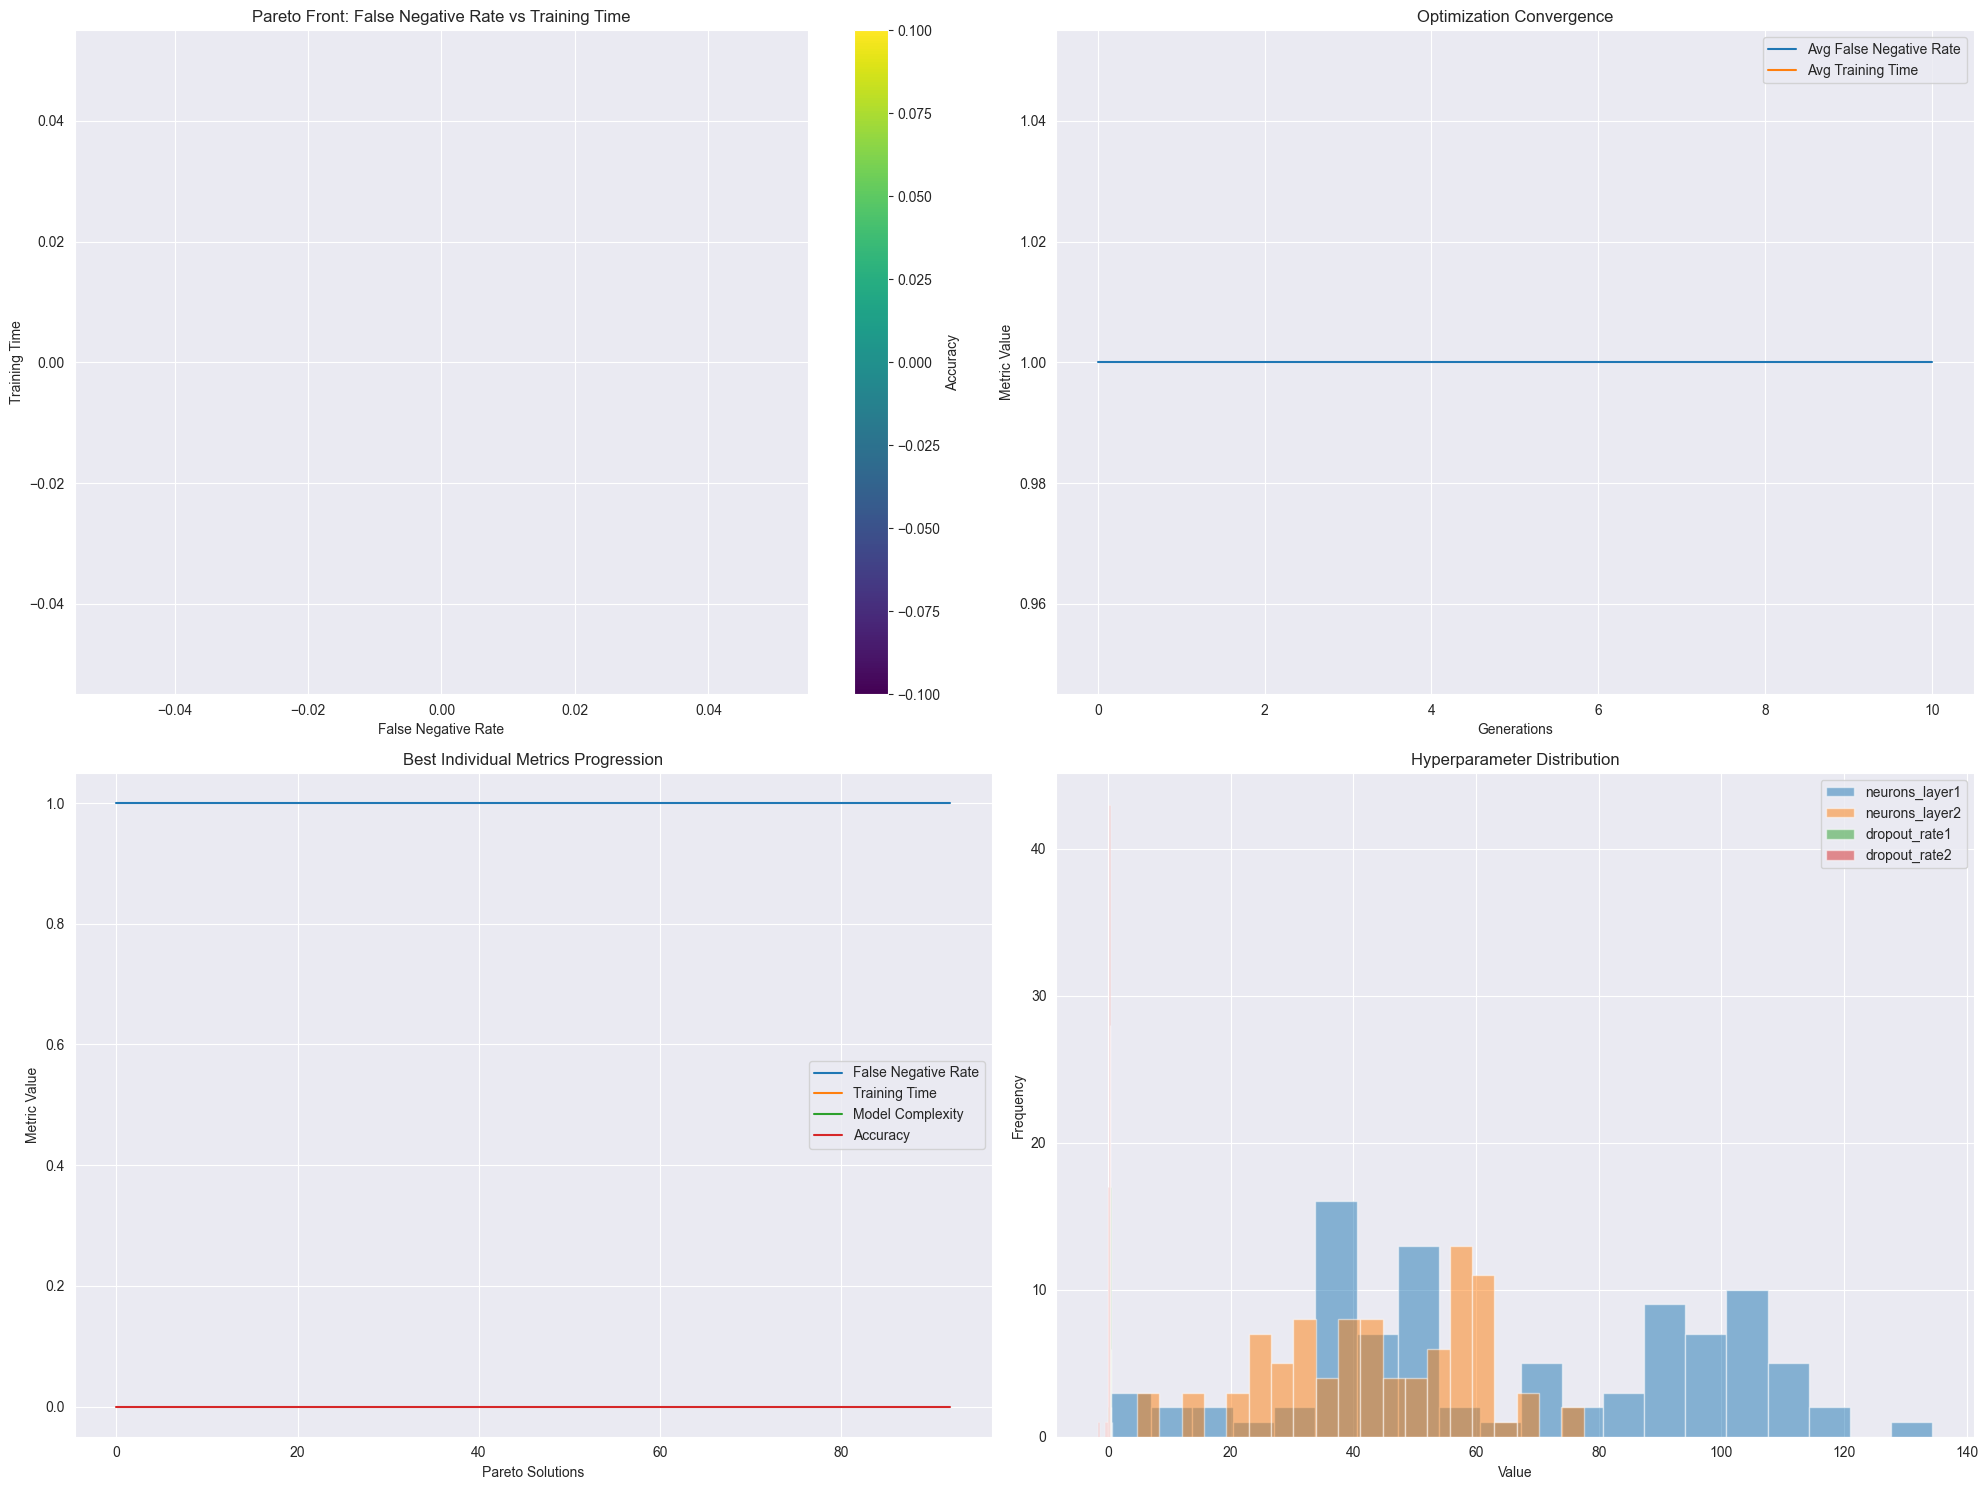

C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.3875, val_loss=0.2816]

Epoch 1 took 1.4088 seconds


Training Progress:   0%|          | 0/5 [00:01<?, ?epoch/s, loss=0.2764, val_loss=0.2539]

Epoch 2 took 0.2666 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2568, val_loss=0.2467]

Epoch 3 took 0.2786 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2518, val_loss=0.2452]

Epoch 4 took 0.2513 seconds


Training Progress:   0%|          | 0/5 [00:02<?, ?epoch/s, loss=0.2371, val_loss=0.2392]

Epoch 5 took 0.2678 seconds


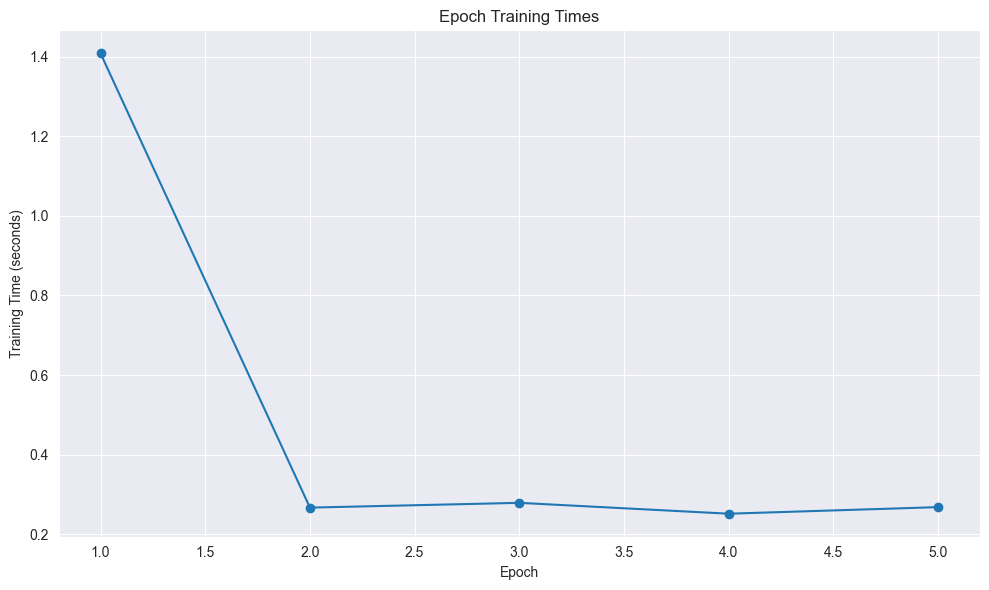

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


ValueError: x must have 2 or fewer dimensions

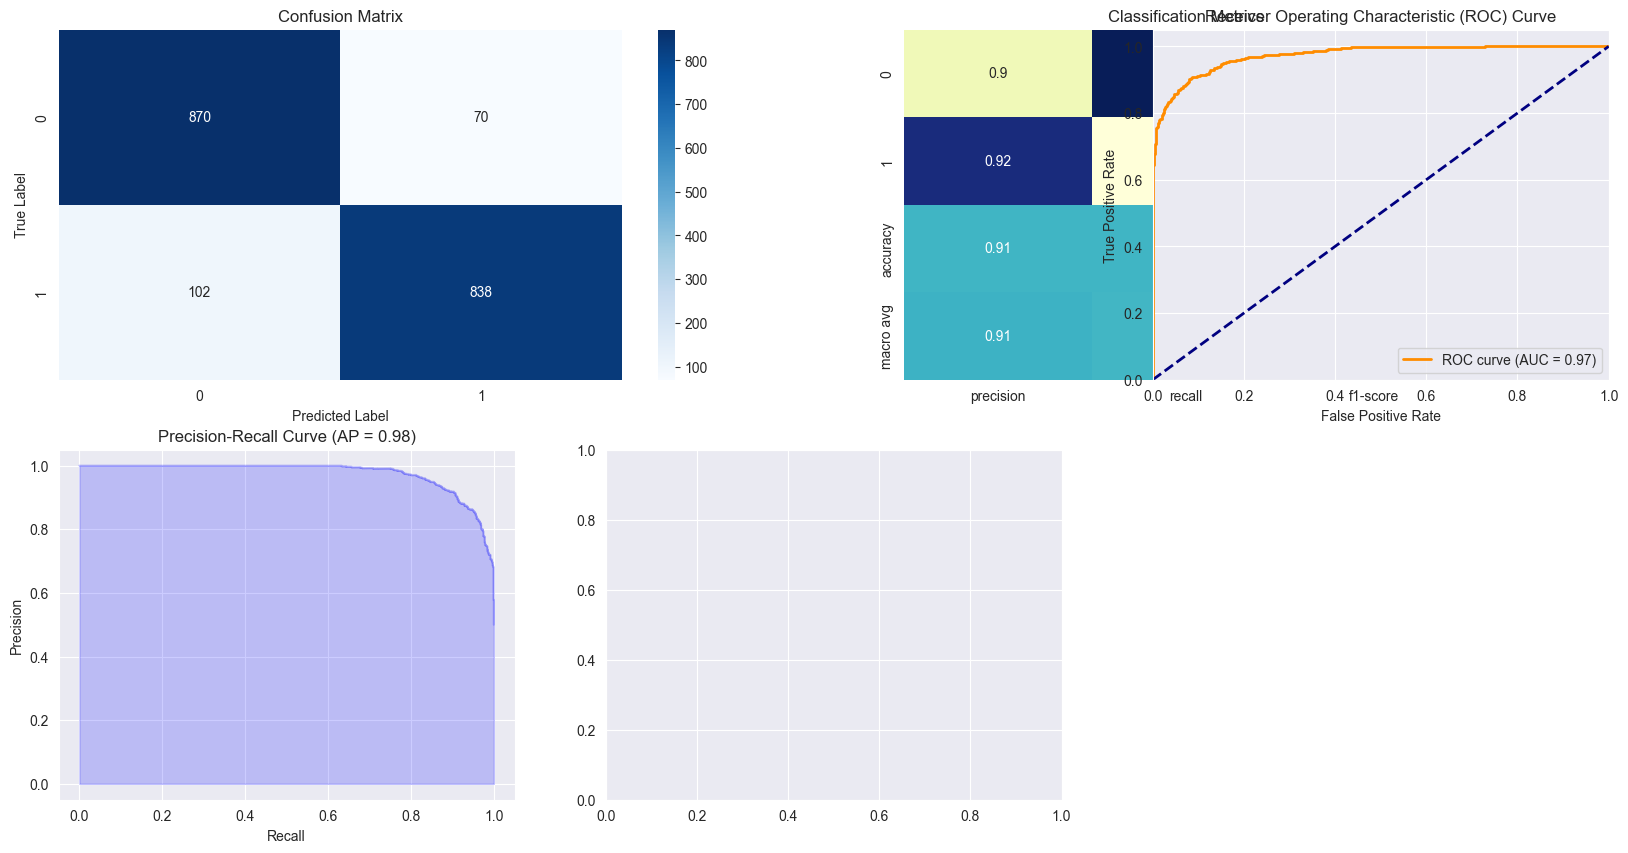

In [79]:
if __name__ == "__main__":
    main()